In [21]:
from tensorflow.keras.layers import Conv2D, Reshape, Concatenate, Flatten, Dropout
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from datetime import datetime as dt
from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import concurrent.futures
import json
import cv2
import os

In [22]:
os.chdir("/mnt/g/Text_detection")

In [23]:
# Ensure GPU memory growth is set if needed
try:
    [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except:
    pass

In [24]:
# Define paths and constants
MODEL_PATH = f"./Models/{dt.now().strftime('%Y%m%d%H%M%S')}/"
json_dir = './Dataset/TextOCR_0.1_train.json'
base_dir = './Dataset/'
batch_size = 4

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

In [25]:
# Load and preprocess data from JSON file
with open(json_dir, 'r') as f:
    data = json.load(f)

In [26]:
# Data generator class
class TextOCRDataGenerator:
    def __init__(self, data, base_dir, batch_size=4, image_size=(224, 224), set_type='train'):
        self.data = data
        self.base_dir = base_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.set_type = set_type
        self.image_ids = [img_id for img_id, img_info in data['imgs'].items() if img_info['set'] == set_type and 'file_name' in img_info]
        self.indexes = np.arange(len(self.image_ids))
        print(f"Initialized with {len(self.image_ids)} images for set '{set_type}'")

    def __len__(self):
        length = len(self.image_ids) // self.batch_size
        print(f"Data generator length (number of batches): {length}")
        return length

    def __data_generation(self, batch_image_ids):
        X = np.empty((self.batch_size, *self.image_size, 3))
        grid_size = 7  # Grid size
        num_boxes = 64  # Number of anchor boxes
        num_coords = 4  # (x1, y1, x2, y2)
        num_classes = 2  # Background and text
        y = np.zeros((self.batch_size, grid_size * grid_size * num_boxes, num_coords + num_classes))

        for i, img_id in enumerate(batch_image_ids):
            img_info = self.data['imgs'][img_id]
            img_path = os.path.join(self.base_dir, img_info['file_name'])
            img = cv2.imread(img_path)
            if img is None:
                print(f"Image not found: {img_path}")
                continue
            img = cv2.resize(img, self.image_size)
            img = img / 255.0
            X[i, ] = img

            if img_id in self.data['imgToAnns']:
                for ann_id in self.data['imgToAnns'][img_id]:
                    ann = self.data['anns'][ann_id]
                    x1, y1, x2, y2 = ann['bbox']
                    x1 = x1 / img_info['width']
                    y1 = y1 / img_info['height']
                    x2 = x2 / img_info['width']
                    y2 = y2 / img_info['height']
                    
                    # Check for NaNs and infinities
                    if any(np.isnan([x1, y1, x2, y2])) or any(np.isinf([x1, y1, x2, y2])):
                        print(f"Found NaNs or infinities in the annotation for image {img_id}. Skipping this annotation.")
                        continue
                    
                    # Calculate the cell position
                    cell_x = int((x1 + x2) / 2 * grid_size)
                    cell_y = int((y1 + y2) / 2 * grid_size)
                    cell_index = cell_y * grid_size + cell_x

                    for b in range(num_boxes):  # 64 anchor boxes
                        y[i, cell_index * num_boxes + b, :num_coords] = [x1, y1, x2, y2]  # bbox coordinates
                        y[i, cell_index * num_boxes + b, num_coords:] = [0, 1]  # one-hot class (text)

        return X, y

    def __call__(self):
        for start_idx in range(0, len(self.image_ids), self.batch_size):
            end_idx = min(start_idx + self.batch_size, len(self.image_ids))
            batch_image_ids = self.image_ids[start_idx:end_idx]
            yield self.__data_generation(batch_image_ids)

    def clean_data_parallel(self):
        valid_image_ids = []

        def process_image(img_id):
            try:
                X, y = self.__data_generation([img_id])
                if not (np.isnan(X).any() or np.isinf(X).any() or np.isnan(y).any() or np.isinf(y).any()):
                    return img_id
            except Exception as e:
                print(f"Error processing image {img_id}: {e}")
            return None

        print("Checking Dataset...")
        with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
            futures = {executor.submit(process_image, img_id): img_id for img_id in self.image_ids}
            for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
                result = future.result()
                if result is not None:
                    valid_image_ids.append(result)

        return valid_image_ids

In [27]:
# Define the model
def create_model(input_shape=(224, 224, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=he_normal())(x)
    x = Dropout(0.5)(x)  # Added dropout for regularization
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=he_normal())(x)
    x = Dropout(0.5)(x)  # Added dropout for regularization
    
    num_classes = 2  # Background and text
    num_boxes = 64  # 64 anchor boxes
    num_coords = 4  # (x1, y1, x2, y2)
    grid_size = 7  # 7x7 grid

    # Ensure the Conv2D filters match the desired reshape dimensions
    bbox_output = Conv2D(num_boxes * num_coords, (1, 1), activation='linear', name='bbox_output')(x)
    class_output = Conv2D(num_boxes * num_classes, (1, 1), activation='softmax', name='class_output')(x)
    
    # Flatten the outputs before reshaping them
    bbox_output = Flatten()(bbox_output)
    class_output = Flatten()(class_output)

    # Reshape to the desired output shape
    bbox_output = Reshape((grid_size * grid_size * num_boxes, num_coords), name='bbox_output_reshape')(bbox_output)
    class_output = Reshape((grid_size * grid_size * num_boxes, num_classes), name='class_output_reshape')(class_output)

    outputs = Concatenate(axis=-1, name='outputs')([bbox_output, class_output])

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

In [28]:
# Custom callback to monitor NaNs/Infs in loss
class NaNInfMonitor(Callback):
    def on_batch_end(self, batch, logs=None):
        if logs is not None:
            if np.isnan(logs.get('loss')) or np.isinf(logs.get('loss')):
                print(f"NaN or Inf found in loss at batch {batch}")
                self.model.stop_training = True  # Stop training if NaN or Inf is found

In [29]:
# Clean the data
data_generator = TextOCRDataGenerator(data, base_dir, batch_size=batch_size, image_size=(224, 224), set_type='train')
clean_image_ids = data_generator.clean_data_parallel()

Initialized with 21778 images for set 'train'
Checking Dataset...


100%|██████████| 21778/21778 [13:27<00:00, 26.98it/s] 


In [30]:
# Update the generator with clean data
data_generator.image_ids = clean_image_ids

In [31]:
# Define the model
model = create_model()
optimizer = Adam(learning_rate=1e-5, clipnorm=1.0)  # Lower learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [33]:
# Convert the generator to a TensorFlow dataset
output_signature = (
    tf.TensorSpec(shape=(batch_size, 224, 224, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(batch_size, 7 * 7 * 64, 6), dtype=tf.float32)
)

tf_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=output_signature
).repeat().prefetch(tf.data.AUTOTUNE)

In [34]:
# Inspect a single batch from the dataset
for images, labels in tf_dataset.take(1):
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)
    break

Images batch shape: (4, 224, 224, 3)
Labels batch shape: (4, 3136, 6)


In [35]:
# Explicitly define the loss function
loss_fn = tf.keras.losses.CategoricalCrossentropy()

In [36]:
# Custom training loop with NaN/Inf handling in parameters
def custom_training_loop(model, dataset, epochs, steps_per_epoch):
    optimizer = model.optimizer
    train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    
    # Initialize lists to store loss and accuracy history
    history = {'loss': [], 'accuracy': []}

    for epoch in range(epochs):
        print(f"\nStart of epoch {epoch}")
        
        epoch_loss = []
        epoch_accuracy = []

        for step, (x_batch_train, y_batch_train) in enumerate(dataset):
            if step >= steps_per_epoch:
                break
            
            with tf.GradientTape() as tape:
                logits = model(x_batch_train, training=True)
                loss_value = loss_fn(y_batch_train, logits)
                
                # Check for NaNs and infinities in the loss
                if tf.reduce_any(tf.math.is_nan(loss_value)) or tf.reduce_any(tf.math.is_inf(loss_value)):
                    print(f"NaN or Inf loss detected at step {step} in epoch {epoch}. Skipping this batch.")
                    continue

            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            train_acc_metric.update_state(y_batch_train, logits)

            # Check for NaNs and infinities in model parameters
            nan_inf_detected = False
            for weight in model.trainable_weights:
                if tf.reduce_any(tf.math.is_nan(weight)) or tf.reduce_any(tf.math.is_inf(weight)):
                    print(f"NaN or Inf detected in model parameters after step {step} in epoch {epoch}.")
                    nan_inf_detected = True
                    break
            
            if nan_inf_detected:
                print(f"Stopping training due to NaN or Inf in model parameters at step {step} in epoch {epoch}.")
                return history

            epoch_loss.append(loss_value.numpy())
            epoch_accuracy.append(train_acc_metric.result().numpy())

            if step % 100 == 0:
                print(f"Training loss (for one batch) at step {step}: {loss_value.numpy()}")
                print(f"Seen so far: {(step + 1) * batch_size} samples")

        # Compute the mean loss and accuracy for the epoch
        mean_epoch_loss = np.mean(epoch_loss)
        mean_epoch_accuracy = np.mean(epoch_accuracy)

        print(f"Training loss over epoch: {mean_epoch_loss}")
        print(f"Training accuracy over epoch: {mean_epoch_accuracy}")
        
        # Append to history
        history['loss'].append(mean_epoch_loss)
        history['accuracy'].append(mean_epoch_accuracy)

        train_acc_metric.reset_states()

    return history

In [37]:
# Start custom training loop and store history
history = custom_training_loop(model, tf_dataset, epochs=10, steps_per_epoch=len(data_generator))

Data generator length (number of batches): 4728

Start of epoch 0
Training loss (for one batch) at step 0: 2.5942912101745605
Seen so far: 4 samples
Training loss (for one batch) at step 100: 2.7891650199890137
Seen so far: 404 samples
Training loss (for one batch) at step 200: 2.814591646194458
Seen so far: 804 samples
Training loss (for one batch) at step 300: 2.7442843914031982
Seen so far: 1204 samples
Training loss (for one batch) at step 400: 1.334847331047058
Seen so far: 1604 samples
Training loss (for one batch) at step 500: 3.178107976913452
Seen so far: 2004 samples
Training loss (for one batch) at step 600: 2.6070315837860107
Seen so far: 2404 samples
Training loss (for one batch) at step 700: 1.9567266702651978
Seen so far: 2804 samples
Training loss (for one batch) at step 800: 1.6604807376861572
Seen so far: 3204 samples
Training loss (for one batch) at step 900: 1.4883748292922974
Seen so far: 3604 samples
Training loss (for one batch) at step 1000: 2.2371127605438232
S

In [38]:
# Save the model
model.save(f"{MODEL_PATH}/model.h5", save_format="h5")

In [39]:
# Plot the training results
def plot_training_results(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train'], loc='upper left')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train'], loc='upper left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

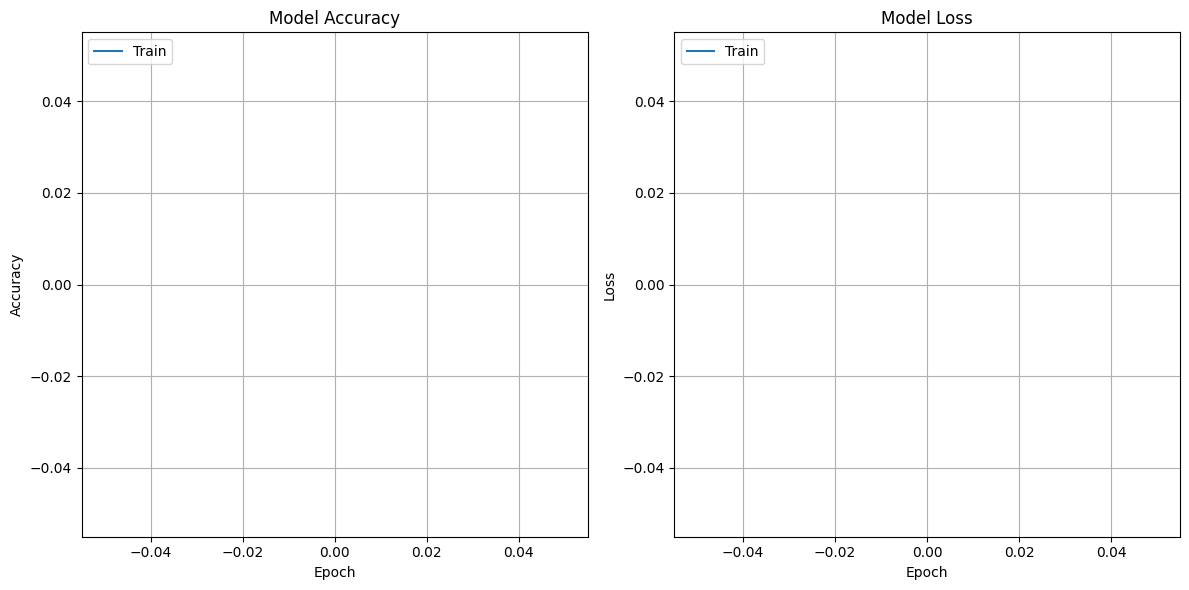

In [40]:
# Plot the results
plot_training_results(history)